In [1]:
from nets import *
import tensorflow as tf 
import misc
from buffer import ReplayBuffer
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from misc import Prob, ps_maxlik, qval

In [2]:
critic = Critic(nature="primary", dolinar_layers = 1)
critic_target = Critic(nature="target", dolinar_layers = 1, tau=0.01)
optimizer_critic = tf.keras.optimizers.Adam(lr=0.01)
experiences = np.load("buffers/1L_probs-0-2.npy")
buffer = ReplayBuffer(buffer_size=10**7)
for k in tqdm(experiences):
    buffer.add(tuple(k))

100%|██████████| 100000/100000 [00:00<00:00, 524791.14it/s]


In [3]:
total_episodes = 10**4
evolution_loss=[]
history_predictions={"final_episode_info":total_episodes}
bbbs = np.arange(0,2.05,.05)
inps = np.stack([np.ones(len(bbbs))*critic.pad_value, bbbs], axis=1)
inps = np.reshape(inps, (len(bbbs),1,2))


In [4]:
for iteration in tqdm(range(total_episodes)):

    sampled_dataset = buffer.sample(64).astype(np.float32)
    batched_sampled_dataset, rews_per_layer = critic.process_sequence_tf(sampled_dataset)
    td_errors = critic_target.give_td_errors_tf(batched_sampled_dataset, rews_per_layer)
    loss = critic.step_critic_tf(batched_sampled_dataset, td_errors, optimizer_critic)
    evolution_loss.append(loss.numpy())
    critic_target.update_target_parameters(critic)
    if iteration%(int(total_episodes/5)) == 0:
        history_predictions[str(iteration)] = {"[]":[], "00":[],"01":[],"11":[],"10":[]}
        history_predictions[str(iteration)]["[]"] = np.squeeze(critic(inps))
        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                history_predictions[str(iteration)][str(outcome)+str(guess_index)] = np.squeeze(critic(tf.stack(m, axis=0)))[:,1]

  0%|          | 0/10000 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10000/10000 [01:50<00:00, 90.30it/s]


In [5]:
def profiles_kennedy(critic, history_predictions):
    matplotlib.rc('font', serif='cm10')
    plt.rcParams.update({'font.size': 100})
    plt.figure(figsize=(150,150), dpi=50)


    ax1 = plt.subplot2grid((2,2),(0,0))
    ax2 = plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
    #betas = np.arange(.1,1.1,.05)
    betas = np.arange(0,2.05,.05)
    if history_predictions!=False:
        axs = {"0":ax1, "1":ax2}
        for ind, epi in enumerate(history_predictions.keys()):
            if epi != "final_episode_info":

                transp_epi = float(epi)/history_predictions["final_episode_info"]
                ax3.plot(betas,history_predictions[epi]["[]"] , alpha=transp_epi, linewidth=3,label=str(epi))
                for outcome in [0.,1.]:
                   for guess_index in [0.,1.]:
                       axs[str(int(outcome))].plot(betas, history_predictions[epi][str(outcome)+str(guess_index)] , alpha=transp_epi, linewidth=3,label=str(epi))#+"-g:"+str((-1)**guess_index))



    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), '--', color="black", linewidth=10,label="RNN")

    axes = {"0.0":ax1, "1.0":ax2}
    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], '--', color="black", linewidth=10,label="RNN")


    ax1.plot(betas,[qval(b, 0, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,ps_maxlik(betas), linewidth=7, color="red", label="P*")

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})



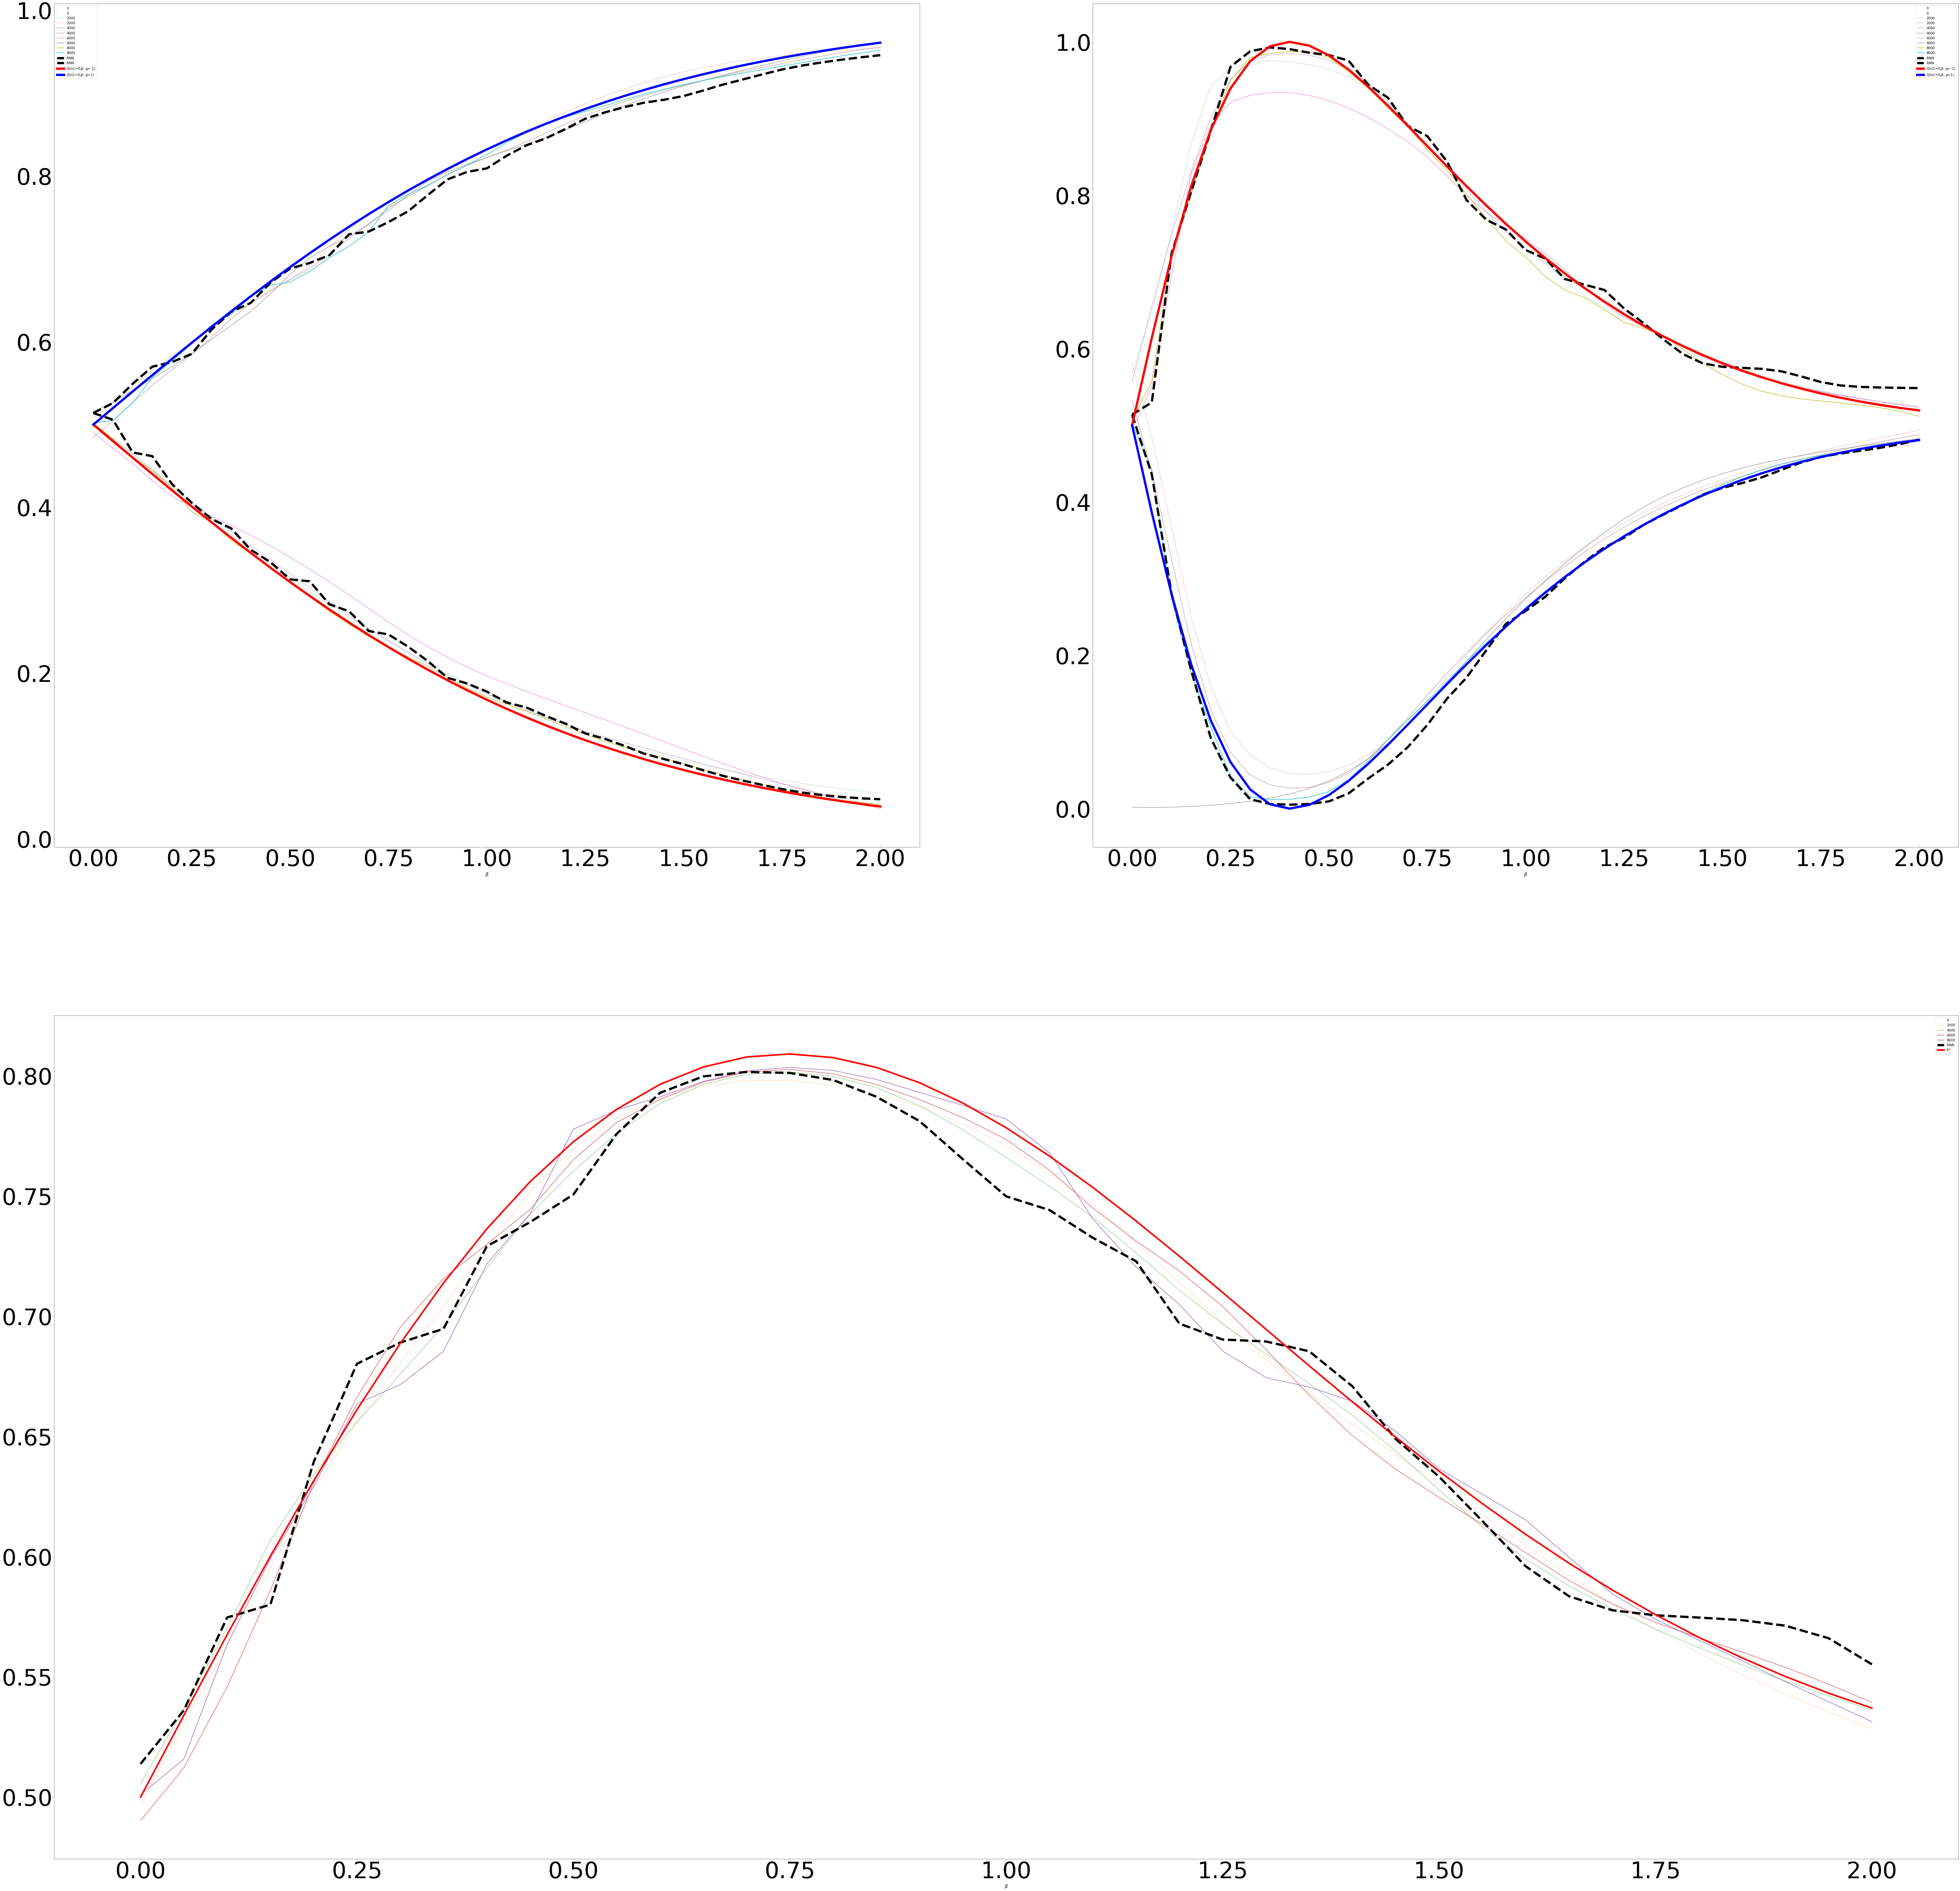

In [6]:
profiles_kennedy(critic, history_predictions)

Ok, pretty nice but for the flat peak. Let's see the actor

In [7]:
def critic_grad_tf(critic, experiences):
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    actions_wathed_index = []
    for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
        actions_wathed_index.append(index)
        to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

    actions_indexed = tf.concat(to_stack,axis=1)
    
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(actions_indexed)
        
        index_actions=0
        watched_exps=[tf.ones((experiences.shape[0],1,1))*critic.pad_value]
        watched_actions_unstacked = tf.unstack(actions_indexed, axis=1)
        for index in range(0,experiences.shape[-1]-1):
            if index in actions_wathed_index:
                watched_exps.append(tf.expand_dims(watched_actions_unstacked[index_actions], axis=2))
                index_actions+=1
            else:
                watched_exps.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

        qvals = critic(tf.reshape(tf.concat(watched_exps, axis=2), (experiences.shape[0],critic.dolinar_layers+1,2)))
        qvalsunstckd = tf.unstack(qvals, axis=1)
        return [tape.gradient(q, actions_indexed) for q in qvalsunstckd]


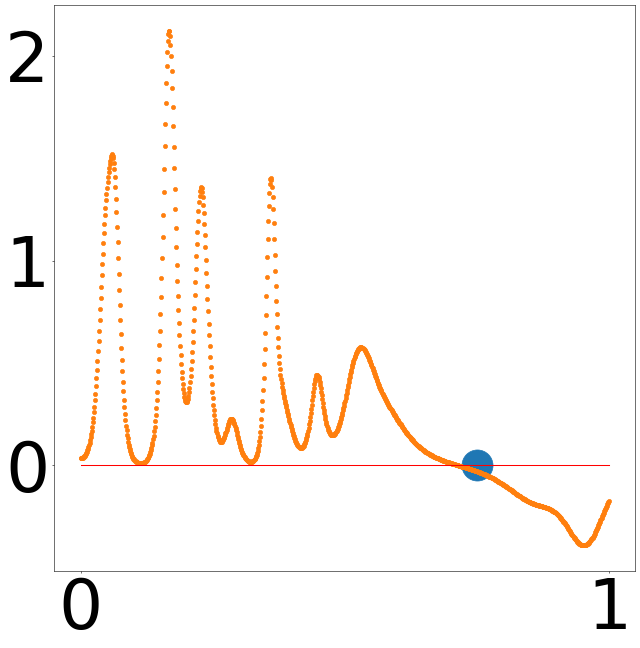

In [8]:
optimal_beta= 0.7499999999999993
samm = np.random.randn(1000,4)
samm[:,0] = np.linspace(0,1,1000)
matplotlib.rc('font', serif='cm10')
plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(15,15), dpi=50)
plt.plot([0,1],[0,0], color="red")
plt.scatter([optimal_beta],[0],s=2000)
plt.scatter(np.linspace(0,1,1000),np.squeeze(critic_grad_tf(critic, samm.astype(np.float32))[0]))

In [9]:
actor = Actor(nature="primary", dolinar_layers= 1)
optimizer_actor = tf.keras.optimizers.Adam(lr=0.01)
samples = buffer.sample(64).astype(np.float32)

We see it's pretty well in identifying the maximum; Notice we are using sigmoid/tanh activation functions; if RELU are used, then discontinuities in the derivative's estimation appear, but "from my experiments", they have more expressivity

Let's train the actor now !

In [ ]:
class Actor1(tf.keras.Model):
    def __init__(self, nature, seed_val=0.01, pad_value = -7.,
                 dolinar_layers=2,tau=0.01,dropout_rate=0.0):
        super(Actor1,self).__init__()
        self.dolinar_layers = dolinar_layers
        self.pad_value = pad_value
        self.nature = nature
        self.tau = tau

        self.output_lstm = 250
        self.lstm = tf.keras.layers.LSTM(self.output_lstm, return_sequences=False, stateful=False, input_shape=(1,1))
        self.mask = tf.keras.layers.Masking(mask_value=pad_value, input_shape=(1,1))


        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val), dtype='float32')

        self.l2 = Dense(10, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val), dtype='float32')

        self.l3 = Dense(10, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val), dtype='float32')

        self.l4 = Dense(1,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val), dtype='float32')

    def call(self, inputs):
        feat = tf.squeeze(self.mask(tf.expand_dims(inputs, axis=-1)), axis=-1)
        #feat = self.lstm(feat)
        #feat = tf.nn.dropout(feat, rate=self.dropout_rate)
        feat = tf.nn.sigmoid(self.l1(feat))
        # feat = tf.nn.dropout(feat, rate=self.dropout_rate)
        feat = tf.nn.sigmoid(self.l2(feat))
        # feat = tf.nn.sigmoid(self.l3(feat))
        feat = tf.nn.sigmoid(self.l4(feat))
        # feat = tf.clip_by_value(feat, 0.0, 1.0)
        return feat


In [13]:
actor =  Actor(nature="primary", dolinar_layers= 1)
optimizer_actor = tf.keras.optimizers.Adam(lr=0.05)


In [26]:
def process_sequence_of_experiences_tf(actor, experiences):
    #### this is trivial for dolianr_layers = 1 #####
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    for index in range(2*actor.dolinar_layers-1): # I consider from first outcome to last one (but guess)
        if (index==0):
            if actor.nature == "target":
                to_stack.append(unstacked_exp[index])
            else:
                to_stack.append(tf.squeeze(actor(tf.ones((experiences.shape[0], 1, 1))*actor.pad_value)))
        if (index%2 == 1):
            to_stack.append(unstacked_exp[index])
            to_stack.append(tf.squeeze(actor(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))))
    for index in range(2*actor.dolinar_layers-1, 2*actor.dolinar_layers+2):
        to_stack.append(unstacked_exp[index])

    if actor.dolinar_layers>1:
        actor.reset_states() #otherwise is like not doing anything so no problem :-)
    else:
        tf.reshape(unstacked_exp[1],(experiences.shape[0],1,1)) #just call it once to initialize
    return tf.stack(to_stack, axis=1)

In [155]:
actor= Actor(nature="primary", dolinar_layers=1)
betas_would_do=[]
optimizer_actor = tf.keras.optimizers.Adam(lr=0.0001)
for k in tqdm(range(10**4)):
    samples = buffer.sample(2).astype(np.float32)
    batched_samples, rews = critic.process_sequence_tf(process_sequence_of_experiences_tf(actor, samples))
    dq_da = critic_grad_tf(critic,process_sequence_of_experiences_tf(actor, samples))[0]
    actor_grad_tf(actor, dq_da, experiences, optimizer_actor)
    betas_would_do.append(np.squeeze(actor(tf.ones((samples.shape[0],1,1))*actor.pad_value))[0])

100%|██████████| 10000/10000 [08:33<00:00, 19.46it/s]


In [156]:
sampless = buffer.sample(512).astype(np.float32)
ff = np.squeeze(critic_grad_tf(critic,sampless)[0])
beta_critic_giving=sampless[:,0][np.where(ff == np.sort(np.abs(ff))[0])[0][0]]


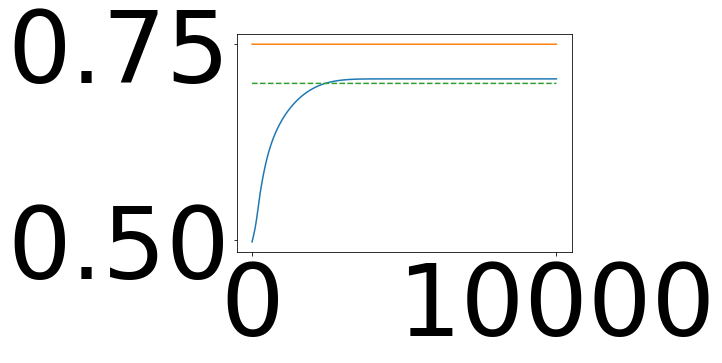

In [157]:
plt.plot(betas_would_do)
plt.plot(np.ones(len(betas_would_do))*optimal_beta)
plt.plot(np.ones(len(betas_would_do))*beta_critic_giving,'--')
